C:\Users\ArunPrasath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


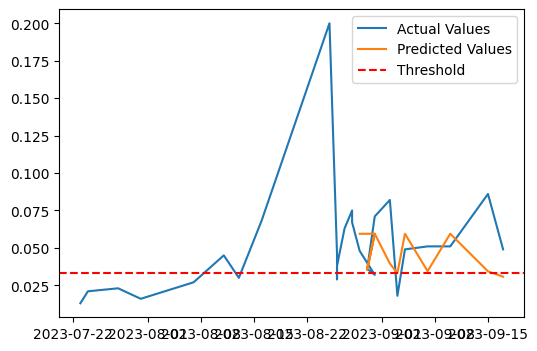

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tkinter import Tk, Label, Button, Entry, filedialog, Canvas, Text, Scrollbar, RIGHT, Y, Frame
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
import os

class IndustryPredictionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Industry Deviation Prediction")

        # Main Frames for layout
        left_frame = Frame(root)
        left_frame.pack(side="left", padx=10, pady=10)

        right_frame = Frame(root)
        right_frame.pack(side="right", padx=10, pady=10)

        # Load Data Button in Left Frame
        self.load_button = Button(left_frame, text="Load Excel Data", command=self.load_data)
        self.load_button.pack(pady=10)

        # Number of Parts Entry in Left Frame
        self.parts_label = Label(left_frame, text="Enter number of parts:")
        self.parts_label.pack()
        self.parts_entry = Entry(left_frame)
        self.parts_entry.pack(pady=5)

        # Result Label in Left Frame
        self.result_label = Label(left_frame, text="")
        self.result_label.pack(pady=10)

        # Canvas for Image Display in Left Frame
        self.canvas = Canvas(left_frame, width=400, height=200)
        self.canvas.pack()
        self.display_image("C:/Users/ArunPrasath/Downloads/ii.jpg")

        # Predict Button in Left Frame
        self.predict_button = Button(left_frame, text="Predict Deviation Date", command=self.predict_deviation)
        self.predict_button.pack(pady=10)

        # Text widget to display deviation details in Left Frame
        self.deviation_text = Text(left_frame, height=15, width=50)
        self.deviation_text.pack(pady=10)

        # Scrollbar for Text widget
        scrollbar = Scrollbar(left_frame, command=self.deviation_text.yview)
        scrollbar.pack(side=RIGHT, fill=Y)
        self.deviation_text.config(yscrollcommand=scrollbar.set)

        # Right Frame for Plot
        self.plot_frame = right_frame

    def display_image(self, img_path):
        if os.path.exists(img_path):
            img = Image.open(img_path).resize((400, 200))
        else:
            img = Image.new("RGB", (400, 200), color="gray")
        
        img_tk = ImageTk.PhotoImage(img)
        self.canvas.create_image(0, 0, anchor="nw", image=img_tk)
        self.canvas.image = img_tk

    def load_data(self):
        file_path = filedialog.askopenfilename(title="Select Excel File", filetypes=[("Excel files", "*.xlsx *.xls")])
        if file_path:
            self.df = pd.read_excel(file_path)
            self.preprocess_data()
            self.result_label.config(text="Data Loaded and Preprocessed")

    def preprocess_data(self):
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df.set_index('Date', inplace=True)
        self.df['Squareness'] = self.df['Values'].rolling(window=3).mean() - self.df['Values'].shift(1)
        self.df['Rolling_Mean'] = self.df['Values'].rolling(window=3).mean()
        self.df['Month'] = self.df.index.month
        self.df['Day'] = self.df.index.day
        self.df['DayOfWeek'] = self.df.index.dayofweek
        self.df['Lag_1'] = self.df['Values'].shift(1)
        self.df['Lag_2'] = self.df['Values'].shift(2)
        self.df.dropna(inplace=True)

    def predict_deviation(self):
        if self.df.shape[0] == 0:
            self.result_label.config(text="No data available for prediction")
            return

        # Get the number of parts from the Entry widget
        try:
            n_parts_per_day = int(self.parts_entry.get())
            if n_parts_per_day <= 0:
                raise ValueError
        except ValueError:
            self.result_label.config(text="Please enter a valid positive integer for the number of parts.")
            return

        X = self.df[['Rolling_Mean', 'Month', 'Day', 'DayOfWeek', 'Lag_1', 'Lag_2', 'Squareness']]
        y = self.df['Values']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
        model = GradientBoostingRegressor(random_state=42)
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        self.result_label.config(text=f"Model RMSE: {rmse:.4f}")

        self.plot_graph(y_pred)
        self.predict_future_deviation(best_model, n_parts_per_day)

    def plot_graph(self, y_pred):
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(self.df.index, self.df['Values'], label='Actual Values')
        ax.plot(self.df.index[len(self.df) - len(y_pred):], y_pred, label='Predicted Values')
        ax.axhline(y=0.033, color='r', linestyle='--', label='Threshold')
        ax.legend()
        
        # Clear previous graph
        for widget in self.plot_frame.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def predict_future_deviation(self, best_model, n_parts_per_day):
        future_date = self.df.index[-1]
        exceeded_part = None
        
        self.deviation_text.delete("1.0", "end")  # Clear previous results

        for part in range(1, n_parts_per_day + 1):  # Loop only up to the number of parts entered
            future_features = pd.DataFrame({
                'Rolling_Mean': [self.df['Rolling_Mean'].iloc[-3:].mean()],
                'Month': [future_date.month],
                'Day': [future_date.day],
                'DayOfWeek': [future_date.dayofweek],
                'Lag_1': [self.df['Values'].iloc[-1]],
                'Lag_2': [self.df['Values'].iloc[-2]],
                'Squareness': [self.df['Squareness'].iloc[-1]]
            }).ffill().bfill()
            
            future_pred = best_model.predict(future_features)[0]
            future_date += pd.Timedelta(days=1 / n_parts_per_day)

            self.deviation_text.insert("end", f"Part {part}: {future_pred:.4f}\n")
            
            if future_pred > 0.066 and exceeded_part is None:
                exceeded_part = part

        if exceeded_part is not None:
            deviation_date = future_date
            self.result_label.config(
                text=f"Deviation exceeds 0.066 on {deviation_date.strftime('%Y-%m-%d')} "
                     f"(Day: {deviation_date.strftime('%A')}) with predicted value: {future_pred:.4f}"
            )
        else:
            self.result_label.config(text="Deviation did not exceed 0.066 in the specified parts.")

root = Tk()
app = IndustryPredictionApp(root)
root.mainloop()
